# Testing maps capabilities

## Reading map file

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET

# Read the GPX file
with open('Southampton_Common.gpx', 'r') as file:
    gpx_content = file.read()

# Parse the XML content
root = ET.fromstring(gpx_content)

# Define the namespace for GPX files
namespace = {'gpx': 'http://www.topografix.com/GPX/1/1'}

# Extract coordinates from track points and waypoints
coordinates = []

# Look for track points (trkpt)
for trkpt in root.findall('.//gpx:trkpt', namespace):
    lat = float(trkpt.get('lat'))
    lon = float(trkpt.get('lon'))
    coordinates.append({'latitude': lat, 'longitude': lon})

# Look for waypoints (wpt) if no track points found
if not coordinates:
    for wpt in root.findall('.//gpx:wpt', namespace):
        lat = float(wpt.get('lat'))
        lon = float(wpt.get('lon'))
        coordinates.append({'latitude': lat, 'longitude': lon})

# Create DataFrame
Common_Park_Coord = pd.DataFrame(coordinates)

print(f"Successfully loaded {len(Common_Park_Coord)} coordinate points")
print("\nDataFrame info:")
print(Common_Park_Coord.info())
print("\nFirst 5 rows:")
print(Common_Park_Coord.head())

Successfully loaded 336 coordinate points

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   336 non-null    float64
 1   longitude  336 non-null    float64
dtypes: float64(2)
memory usage: 5.4 KB
None

First 5 rows:
    latitude  longitude
0  50.921568  -1.404920
1  50.921330  -1.404855
2  50.921331  -1.405070
3  50.921373  -1.405091
4  50.921438  -1.405263


## Tranforming the coordinates and plotting the map


DataFrame with Euclidean coordinates:
    latitude  longitude         x         y
0  50.921568  -1.404920  1.356091  0.268355
1  50.921330  -1.404855  1.362562  0.244617
2  50.921331  -1.405070  1.341105  0.244626
3  50.921373  -1.405091  1.338959  0.248909
4  50.921438  -1.405263  1.321793  0.255355


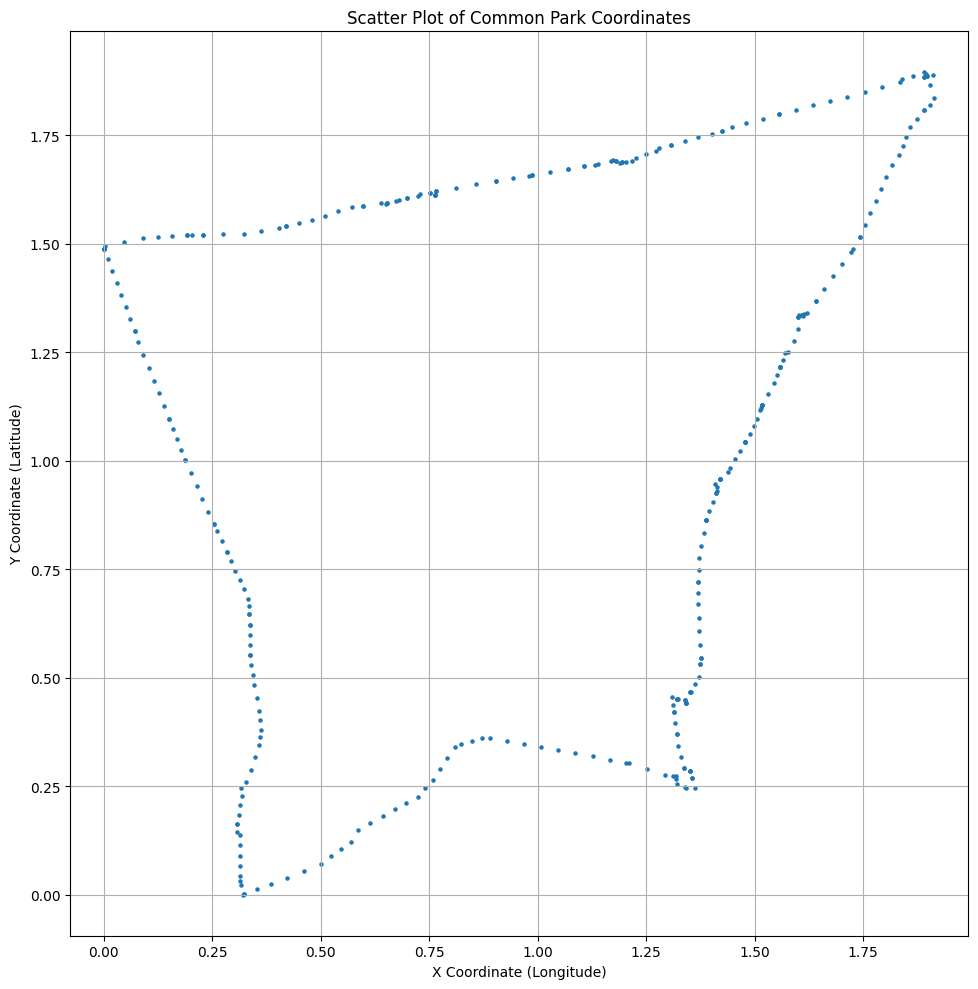

In [2]:
# Converting latitude and longitude to euclidean coordinates, where the origing is the south-west corner of the map
Common_Park_Coord['x'] = 100 * (Common_Park_Coord['longitude'] - Common_Park_Coord['longitude'].min())
Common_Park_Coord['y'] = 100 * (Common_Park_Coord['latitude'] - Common_Park_Coord['latitude'].min())

print("\nDataFrame with Euclidean coordinates:")
print(Common_Park_Coord.head())

# Plotting the coordinates into a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(Common_Park_Coord['x'], Common_Park_Coord['y'], alpha=1.0, s=5)
plt.title('Scatter Plot of Common Park Coordinates')
plt.xlabel('X Coordinate (Longitude)')
plt.ylabel('Y Coordinate (Latitude)')
plt.axis('equal')  # This ensures the plot is properly squared
plt.grid()
plt.tight_layout()
plt.show()

## Polygonal

Created polygon with 8 vertices
Polygon vertices (x, y coordinates):
  Vertex 1: (1.363, 0.245)
  Vertex 2: (1.914, 1.837)
  Vertex 3: (1.910, 1.888)
  Vertex 4: (1.890, 1.895)
  Vertex 5: (0.002, 1.496)
  Vertex 6: (0.000, 1.487)
  Vertex 7: (0.000, 1.487)
  Vertex 8: (0.320, 0.000)


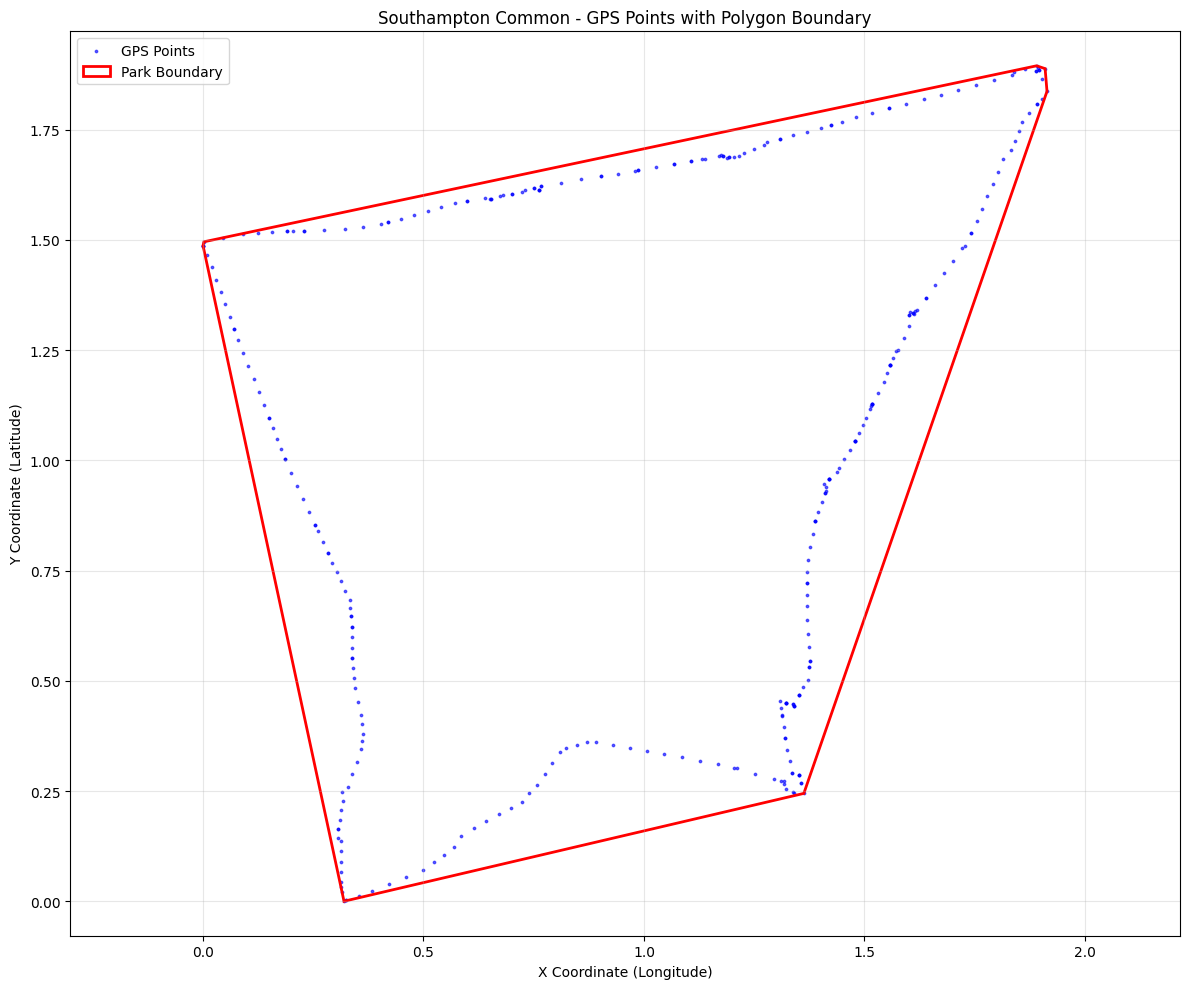

In [3]:
from matplotlib.patches import Polygon
from matplotlib.path import Path
import numpy as np

# Create polygon from the coordinates
# Sort points to create a proper boundary (this creates a convex hull-like boundary)
from scipy.spatial import ConvexHull

# Extract x, y coordinates
points = Common_Park_Coord[['x', 'y']].values

# Create convex hull to get the boundary polygon
hull = ConvexHull(points)
hull_points = points[hull.vertices]

# Store the polygon parameters
park_polygon_vertices = hull_points
park_polygon_path = Path(park_polygon_vertices)

print(f"Created polygon with {len(park_polygon_vertices)} vertices")
print("Polygon vertices (x, y coordinates):")
for i, vertex in enumerate(park_polygon_vertices):
    print(f"  Vertex {i+1}: ({vertex[0]:.3f}, {vertex[1]:.3f})")

# Plot the original points with the polygon boundary
plt.figure(figsize=(12, 10))
plt.scatter(Common_Park_Coord['x'], Common_Park_Coord['y'], alpha=0.6, s=3, c='blue', label='GPS Points')

# Create and add the polygon patch
polygon_patch = Polygon(park_polygon_vertices, fill=False, edgecolor='red', linewidth=2, label='Park Boundary')
plt.gca().add_patch(polygon_patch)

plt.title('Southampton Common - GPS Points with Polygon Boundary')
plt.xlabel('X Coordinate (Longitude)')
plt.ylabel('Y Coordinate (Latitude)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Version 2

Improved polygon with 43 vertices
Original GPS track: 336 points
Simplified using every 8 points


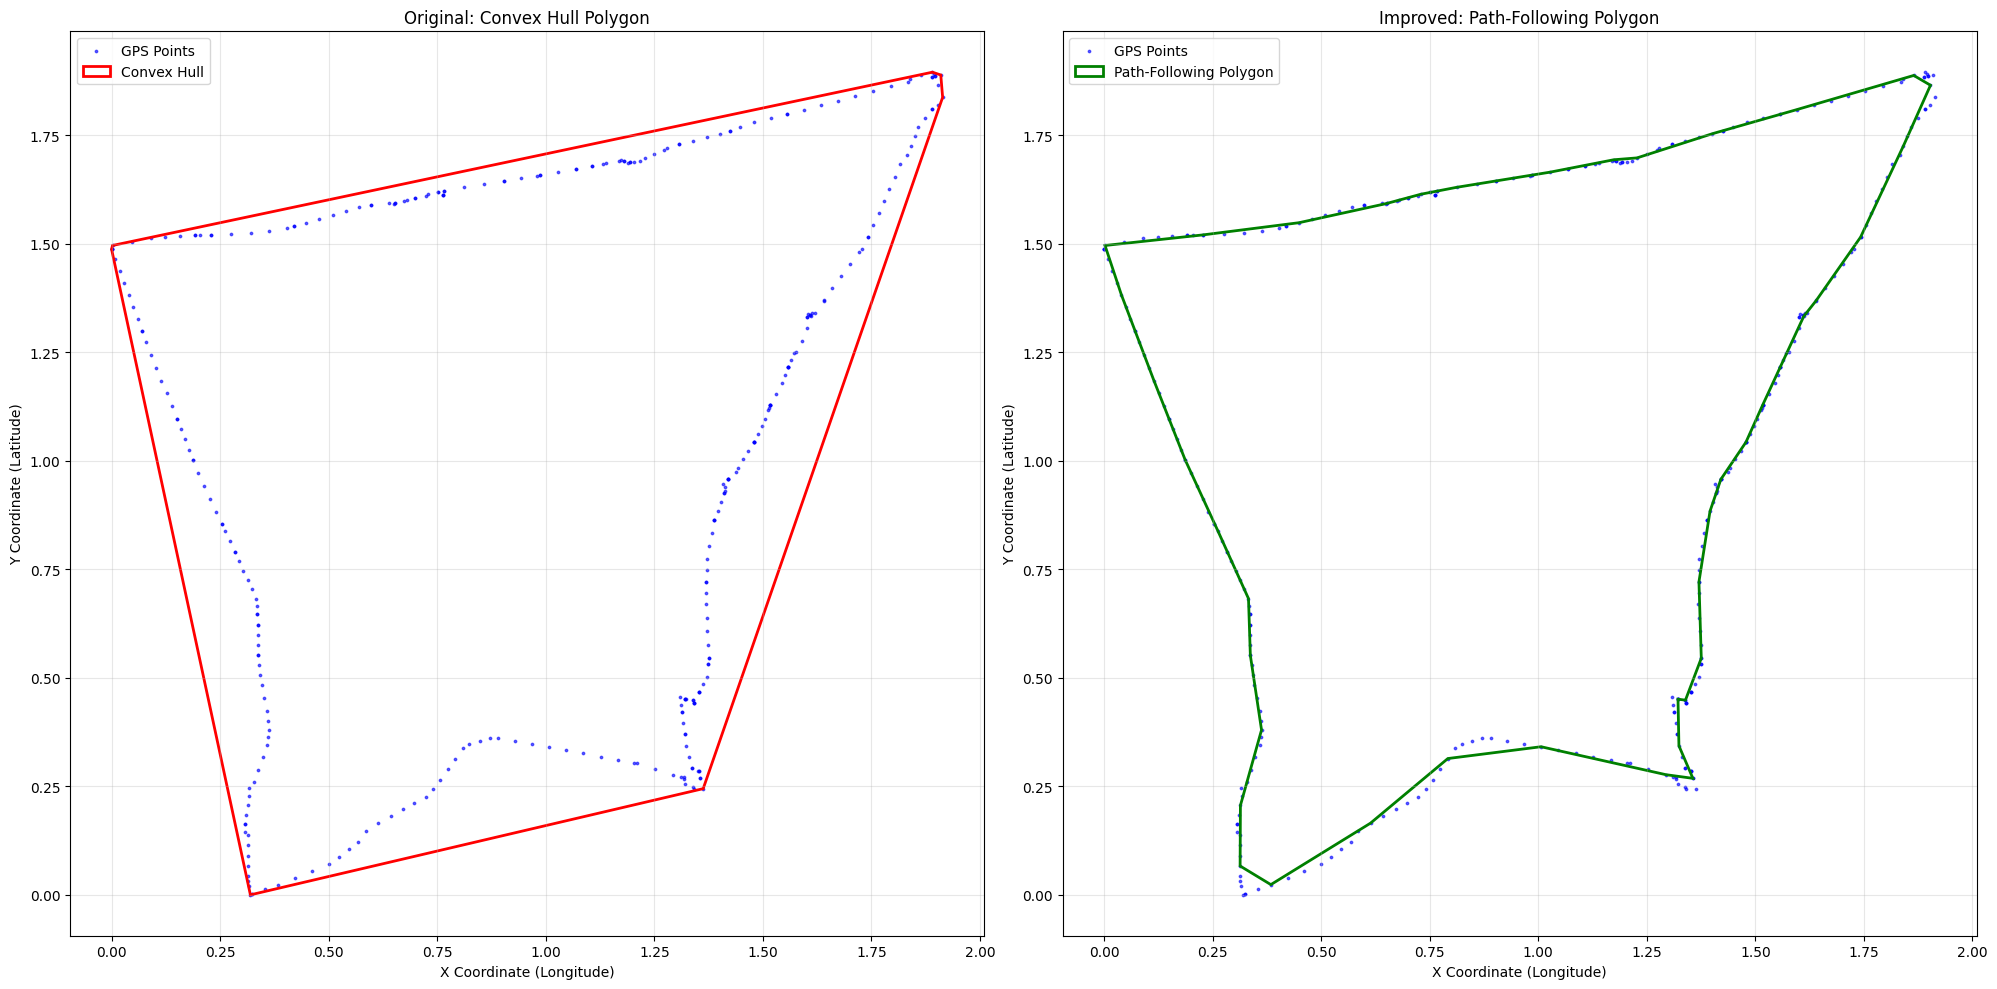


Polygon parameters updated:
- park_polygon_vertices: Now uses path-following approach (43 vertices)
- park_polygon_path: Updated for point-in-polygon testing


In [4]:
# Improved polygon that connects the GPS points more closely
# Since the GPS points form a path, we'll use them in order but with some simplification

import numpy as np
from matplotlib.patches import Polygon
from matplotlib.path import Path

# Extract x, y coordinates (already available from previous cells)
points = Common_Park_Coord[['x', 'y']].values

# Method: Use every nth point to simplify while maintaining the path shape
# This creates a polygon that follows the actual GPS track more closely than convex hull
step_size = max(1, len(points) // 40)  # Reduce to about 40 points for cleaner polygon
simplified_points = points[::step_size]

# Ensure the polygon is closed by connecting back to start
if not np.allclose(simplified_points[0], simplified_points[-1], atol=1e-10):
    simplified_points = np.vstack([simplified_points, simplified_points[0]])

# Store the improved polygon parameters  
improved_polygon_vertices = simplified_points
improved_polygon_path = Path(improved_polygon_vertices)

print(f"Improved polygon with {len(improved_polygon_vertices)} vertices")
print(f"Original GPS track: {len(points)} points")
print(f"Simplified using every {step_size} points")

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Original convex hull
ax1.scatter(Common_Park_Coord['x'], Common_Park_Coord['y'], alpha=0.6, s=3, c='blue', label='GPS Points')
hull_poly = Polygon(park_polygon_vertices, fill=False, edgecolor='red', linewidth=2, label='Convex Hull')
ax1.add_patch(hull_poly)
ax1.set_title('Original: Convex Hull Polygon')
ax1.set_xlabel('X Coordinate (Longitude)')
ax1.set_ylabel('Y Coordinate (Latitude)')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Improved path-following polygon
ax2.scatter(Common_Park_Coord['x'], Common_Park_Coord['y'], alpha=0.6, s=3, c='blue', label='GPS Points')
improved_poly = Polygon(improved_polygon_vertices, fill=False, edgecolor='green', linewidth=2, label='Path-Following Polygon')
ax2.add_patch(improved_poly)
ax2.set_title('Improved: Path-Following Polygon')
ax2.set_xlabel('X Coordinate (Longitude)')
ax2.set_ylabel('Y Coordinate (Latitude)')
ax2.axis('equal')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Update global variables to use the improved polygon
park_polygon_vertices = improved_polygon_vertices
park_polygon_path = improved_polygon_path

print(f"\nPolygon parameters updated:")
print(f"- park_polygon_vertices: Now uses path-following approach ({len(park_polygon_vertices)} vertices)")
print(f"- park_polygon_path: Updated for point-in-polygon testing")

## Function to determine whether in "inside or outside" the park

In [5]:
# Function to determine if a point is inside or outside the park
def is_point_in_park(x, y):
    """
    Determine if a point (x, y) is inside or outside the park polygon.
    
    Parameters:
    x (float): X coordinate (transformed longitude)
    y (float): Y coordinate (transformed latitude)
    
    Returns:
    str: "inside" if point is within the park boundary, "outside" if not
    """
    point = np.array([x, y])
    is_inside = park_polygon_path.contains_point(point)
    return "inside" if is_inside else "outside"

# Function to check multiple points at once
def check_points_in_park(x_coords, y_coords):
    """
    Check multiple points to see if they're inside or outside the park.
    
    Parameters:
    x_coords (list or array): X coordinates
    y_coords (list or array): Y coordinates
    
    Returns:
    list: List of "inside" or "outside" for each point
    """
    points = np.column_stack((x_coords, y_coords))
    inside_mask = park_polygon_path.contains_points(points)
    return ["inside" if inside else "outside" for inside in inside_mask]

# Test the function with some sample points
print("\n" + "="*50)
print("TESTING THE FUNCTION:")
print("="*50)

# Test with center point (should be inside)
center_x = (Common_Park_Coord['x'].min() + Common_Park_Coord['x'].max()) / 2
center_y = (Common_Park_Coord['y'].min() + Common_Park_Coord['y'].max()) / 2
print(f"Center point ({center_x:.3f}, {center_y:.3f}): {is_point_in_park(center_x, center_y)}")

# Test with a point outside the boundary
outside_x = Common_Park_Coord['x'].max() + 0.5
outside_y = Common_Park_Coord['y'].max() + 0.5
print(f"Outside point ({outside_x:.3f}, {outside_y:.3f}): {is_point_in_park(outside_x, outside_y)}")

# Test with a point at the minimum boundary (should be inside or on edge)
min_x = Common_Park_Coord['x'].min()
min_y = Common_Park_Coord['y'].min()
print(f"Min boundary point ({min_x:.3f}, {min_y:.3f}): {is_point_in_park(min_x, min_y)}")

print(f"\nPolygon parameters are stored in:")
print(f"- park_polygon_vertices: numpy array with {len(park_polygon_vertices)} vertices")
print(f"- park_polygon_path: matplotlib Path object for efficient point-in-polygon testing")


TESTING THE FUNCTION:
Center point (0.957, 0.947): inside
Outside point (2.414, 2.395): outside
Min boundary point (0.000, 0.000): outside

Polygon parameters are stored in:
- park_polygon_vertices: numpy array with 43 vertices
- park_polygon_path: matplotlib Path object for efficient point-in-polygon testing


## Compute the area inside the polygon i.e. area of the park


POLYGON AREA CALCULATIONS
Number of polygon vertices: 43
Area in coordinate units: 1.838603 square units

Real-world area estimates:
Area in square meters: 1,427,802 m²
Area in hectares:      142.78 ha
Area in acres:         352.81 acres


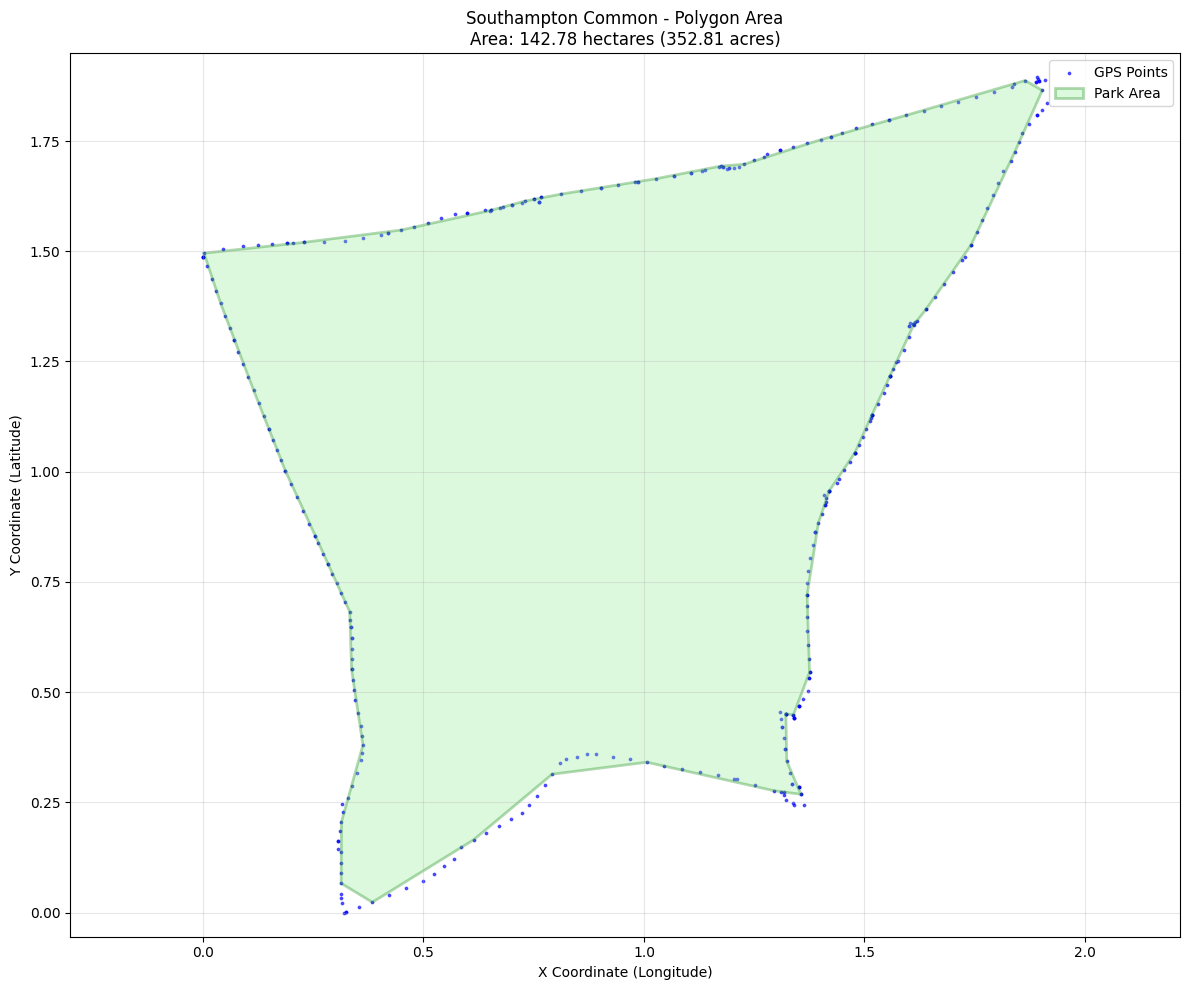

In [6]:
# Compute the area of the park polygon
def compute_polygon_area(vertices):
    """
    Compute the area of a polygon using the Shoelace formula.
    """
    x = vertices[:, 0]
    y = vertices[:, 1]
    # Shoelace formula
    area = 0.5 * abs(sum(x[i] * y[i+1] - x[i+1] * y[i] for i in range(-1, len(x)-1)))
    return area

# Calculate area using the improved polygon
polygon_area = compute_polygon_area(park_polygon_vertices)

print("="*60)
print("POLYGON AREA CALCULATIONS")
print("="*60)
print(f"Number of polygon vertices: {len(park_polygon_vertices)}")
print(f"Area in coordinate units: {polygon_area:.6f} square units")

# Convert to real-world units
lat_avg = Common_Park_Coord['latitude'].mean()
lon_scale_factor = np.cos(np.radians(lat_avg))

# Our coordinates: 100 * (degrees - min_degrees), so 1 unit = 0.01 degrees
meters_per_x_unit = 0.01 * 111000 * lon_scale_factor  # meters per x unit
meters_per_y_unit = 0.01 * 111000  # meters per y unit

area_square_meters = polygon_area * meters_per_x_unit * meters_per_y_unit
area_hectares = area_square_meters / 10000  # 1 hectare = 10,000 m²
area_acres = area_hectares * 2.471  # 1 hectare ≈ 2.471 acres

print(f"\nReal-world area estimates:")
print(f"Area in square meters: {area_square_meters:,.0f} m²")
print(f"Area in hectares:      {area_hectares:.2f} ha")
print(f"Area in acres:         {area_acres:.2f} acres")

# Visualize with filled polygon
plt.figure(figsize=(12, 10))
plt.scatter(Common_Park_Coord['x'], Common_Park_Coord['y'], alpha=0.6, s=3, c='blue', label='GPS Points')

# Create filled polygon
filled_polygon = Polygon(park_polygon_vertices, alpha=0.3, facecolor='lightgreen', edgecolor='green', linewidth=2)
plt.gca().add_patch(filled_polygon)

plt.title(f'Southampton Common - Polygon Area\nArea: {area_hectares:.2f} hectares ({area_acres:.2f} acres)')
plt.xlabel('X Coordinate (Longitude)')
plt.ylabel('Y Coordinate (Latitude)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend(['GPS Points', 'Park Area'])
plt.tight_layout()
plt.show()